In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Generating Synthetic data to using a function

In [ ]:
def basic_math(x):

    return x**2 + 5*x - 13


x_input = torch.arange(-50, 50, step = 0.1)
noise_vector = torch.randn(len(x_input)) * 0.01
y_out = x_input.clone().apply_(basic_math) + noise_vector

# Plotting the Original Function

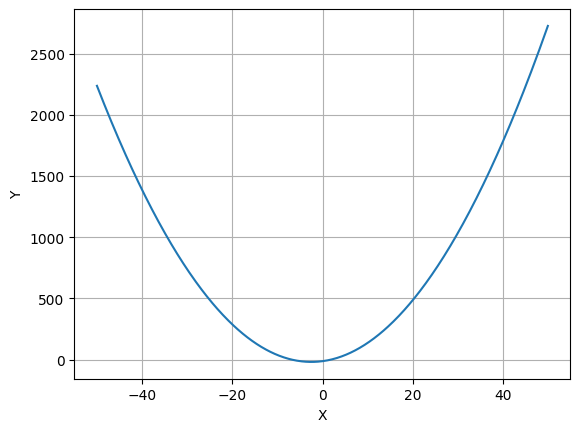

In [ ]:
import matplotlib.pyplot as plt

def plot_x_y(x, y):
    """
    Plots x and y using matplotlib.

    Args:
        x: A list of x-axis values.
        y: A list of y-axis values.
    """
    plt.plot(x, y)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

plot_x_y(x_input, y_out)


# Performing Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

test_x, train_x, test_y, train_y = train_test_split(x_input, y_out, test_size = 0.8)

print(train_x.shape, train_y.shape)

torch.Size([800]) torch.Size([800])


## Dataset Preparation for DataLoader consumption
## Using Dataloader to break the dataset into batches

In [ ]:
print(f"Original shape: train_x: {train_x.shape}, train_y: {train_y.shape}, test_x : {test_x.shape}, test_y: {test_y.shape}")

train_x = train_x.unsqueeze(dim = 1)
test_x = test_x.unsqueeze(dim = 1)

train_y = train_y.unsqueeze(dim = 1)
test_y = test_y.unsqueeze(dim = 1)

print(f"Modified shape: train_x: {train_x.shape}, train_y: {train_y.shape}, test_x : {test_x.shape}, test_y: {test_y.shape}")

Original shape: train_x: torch.Size([800]), train_y: torch.Size([800]), test_x : torch.Size([200]), test_y: torch.Size([200])
Modified shape: train_x: torch.Size([800, 1]), train_y: torch.Size([800, 1]), test_x : torch.Size([200, 1]), test_y: torch.Size([200, 1])


# Constructing a dataset class to be consumed by the DataLoader object
`this was recommended but is not mandatory`



In [ ]:
from torch.utils.data import Dataset
from typing import Union

class CustomDatasetCreator(Dataset):

    def __init__(self, X: torch.tensor, y: torch.tensor):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label


m_train_dataset = CustomDatasetCreator(train_x, train_y)
m_test_dataset = CustomDatasetCreator(test_x, test_y)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
m_BATCH_SIZE = 32


m_train_dtl = DataLoader(m_train_dataset, batch_size = m_BATCH_SIZE, shuffle = True)
m_test_dtl = DataLoader(m_test_dataset, batch_size = m_BATCH_SIZE, shuffle = False)



## Creating Basic Benchmarking NN structure to test

In [ ]:
class MathMapperV1(nn.Module):

    def __init__(self, input_shape: int,
                 hidden_1: int,
                 hidden_2: int,
                 hidden_3: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features = input_shape, out_features = hidden_1),
            nn.ReLU(),
            nn.Linear(in_features = hidden_1, out_features = hidden_2),
            nn.ReLU(),
            nn.Linear(in_features = hidden_2, out_features = hidden_3),
            nn.ReLU(),
            nn.Linear(in_features = hidden_3, out_features = output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

mt_model_1 = MathMapperV1(1, 10, 30, 12, 1)

mt_model_1

MathMapperV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)

## setting the agnostic cuda object

In [ ]:
def compute_object():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return device

device = compute_object()

print(device)

cpu


## Defining my loss function and optimizer

In [ ]:
import torch
from torch import nn
from torch.optim import Adam

m_loss_fn = nn.MSELoss()
m_optimizer = Adam(mt_model_1.parameters(), lr = 0.01)

print("Loss function object created")
print()
print(f"Optimizer allocated to parameters: {mt_model_1} \n")


Loss function object created

Optimizer allocated to parameters: MathMapperV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
) 



## Testing the Input, Output shapes of the Tensor going into the NN as input, prediction output from the NN, and chosen compute device

In [ ]:
print("Input shape: ", next(iter(m_train_dtl))[0].shape)
print("Prediction shape: ", mt_model_1(next(iter(m_train_dtl))[0]).shape)


Input shape:  torch.Size([32, 1])
Prediction shape:  torch.Size([32, 1])


## Defining Regression error metrics

In [ ]:
def mean_squared_error(y_pred: torch.tensor, y_true: torch.tensor):

    return torch.mean(torch.tensor((y_pred - y_true)**2, dtype = torch.float32))


def r2_score_reg(y_pred: torch.tensor, y_true: torch.tensor):

    ss_res = torch.sum(torch.tensor((y_true - y_pred) ** 2, dtype = torch.float32))
    y_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_mean) ** 2)

    r2_score = (1 - (ss_res/ss_tot))

    out_dict = {"ss_res": ss_res,
                "y_mean" : y_mean,
                "ss_tot": ss_tot,
                "r2_score": r2_score}

    return out_dict

### Running the Training the the test loop

### Creating a dictionary to track the progress of the learning through the epochs

`Will be use this to plot it later`

In [ ]:
learning_tracker = {}

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer
#from torcheval.metrics import MeanSquaredError as MSE

torch.manual_seed(40)



start_time = default_timer()

epochs = 100


for epoch in tqdm(range(epochs)):

    print(f"Current Epoch: {epoch} \n")

    train_loss = 0

    for batch, (X, y) in enumerate(m_train_dtl):

        mt_model_1.train()

        ## forward pass
        y_preds = mt_model_1(X)

        ## Calculating the loss for the batch
        loss = m_loss_fn(y_preds, y)
        train_loss += loss

        ## Backward Pass
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

        ## training progress
        if batch % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss.item(): .4f}")

    train_loss /= len(m_train_dtl)

    if (epoch+1)%25 == 0:
        learning_tracker['epoch_'+str(epoch+1)] = mt_model_1(x_input.unsqueeze(dim=1)).squeeze().detach().numpy()

    ## Testing step

    test_loss, mse_error = 0, 0
    r2_score = 0

    mt_model_1.eval()

    with torch.inference_mode():

        test_loss = 0

        for X, y in m_test_dtl:

            ## forward pass
            test_pred = mt_model_1(X)

            ## calculate the loss
            test_loss += m_loss_fn(test_pred, y)

            ## MSE calculation
            mse_error += mean_squared_error(test_pred, y).item()
            r2_score += r2_score_reg(test_pred, y)['r2_score'].item()


        test_loss /= len(m_test_dtl)
        mse_error /= len(m_test_dtl)
        r2_score /= len(m_test_dtl)

    print(f"Train loss: {train_loss: .5f} | Test loss: {test_loss: .5f} \n")
    print(f"Test accuracy: {mse_error: .5f} | r2_score: {r2_score: .5f}")



end_time = default_timer()

print(f"Total run time: {end_time - start_time}")

  0%|          | 0/100 [00:00<?, ?it/s]

Current Epoch: 0 

Epoch: 1, Loss:  1321767.6250
Epoch: 1, Loss:  1256254.8750
Epoch: 1, Loss:  1267033.5000
Train loss:  1211994.87500 | Test loss:  1182287.87500 

Test accuracy:  1182287.88393 | r2_score: -0.94623
Current Epoch: 1 

Epoch: 2, Loss:  1045765.3750
Epoch: 2, Loss:  1407925.8750
Epoch: 2, Loss:  724566.2500
Train loss:  879838.93750 | Test loss:  436871.65625 

Test accuracy:  436871.65625 | r2_score:  0.28076
Current Epoch: 2 

Epoch: 3, Loss:  688672.3750
Epoch: 3, Loss:  278340.0312
Epoch: 3, Loss:  145563.2344
Train loss:  251448.40625 | Test loss:  96457.70312 

Test accuracy:  96457.71484 | r2_score:  0.83995
Current Epoch: 3 

Epoch: 4, Loss:  117597.7812


<ipython-input-64-842b97b099f6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.mean(torch.tensor((y_pred - y_true)**2, dtype = torch.float32))
<ipython-input-64-842b97b099f6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ss_res = torch.sum(torch.tensor((y_true - y_pred) ** 2, dtype = torch.float32))


Epoch: 4, Loss:  97136.0000
Epoch: 4, Loss:  88770.8750
Train loss:  92744.43750 | Test loss:  91874.77344 

Test accuracy:  91874.77455 | r2_score:  0.84677
Current Epoch: 4 

Epoch: 5, Loss:  70077.7109
Epoch: 5, Loss:  68515.1719
Epoch: 5, Loss:  77729.2734
Train loss:  85587.07031 | Test loss:  84886.19531 

Test accuracy:  84886.19754 | r2_score:  0.85863
Current Epoch: 5 

Epoch: 6, Loss:  87924.2734
Epoch: 6, Loss:  88943.9531
Epoch: 6, Loss:  83571.0469
Train loss:  83082.94531 | Test loss:  87989.26562 

Test accuracy:  87989.26395 | r2_score:  0.85372
Current Epoch: 6 

Epoch: 7, Loss:  67722.2656
Epoch: 7, Loss:  61002.4219
Epoch: 7, Loss:  81706.3359
Train loss:  82343.60938 | Test loss:  83482.16406 

Test accuracy:  83482.16127 | r2_score:  0.86113
Current Epoch: 7 

Epoch: 8, Loss:  103295.8438
Epoch: 8, Loss:  67310.1797
Epoch: 8, Loss:  78542.6172
Train loss:  80174.71875 | Test loss:  80135.23438 

Test accuracy:  80135.23438 | r2_score:  0.86646
Current Epoch: 8 

Ep

# Plotting the model progress over the epochs

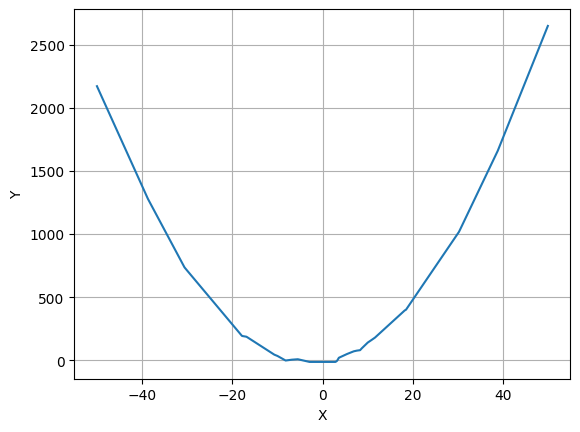

In [ ]:
plot_x_y(x_input, mt_model_1(x_input.unsqueeze(dim=1)).squeeze().detach().numpy())

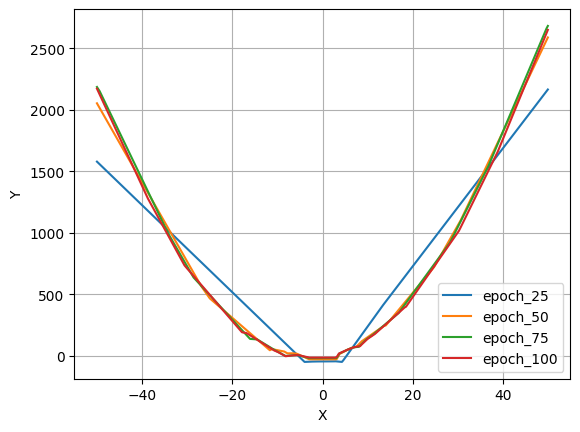

In [ ]:
for curr in learning_tracker.keys():
    plt.plot(x_input, learning_tracker[curr], label = curr)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()